In [9]:
import pandas as pd
import numpy as np
import easyocr
import os
from tqdm import tqdm
# ==============================================================================
# STEP 1: 데이터 준비 (파일 불러오기 및 3개 데이터 병합)
# ==============================================================================
print("STEP 1: 데이터 준비를 시작합니다.")
try:
    # 1. 각 CSV 파일 불러오기
    # Windows 환경에서 저장된 한글 CSV는 'cp949' 인코딩으로 불러옵니다.
    title_df = pd.read_csv("KB Land Video Title.csv")
    thumbnail_df = pd.read_csv("KB Land Video Thumbnail.csv")
    
    # API로 수집한 날짜 데이터는 보통 'utf-8'로 저장됩니다.
    dates_df = pd.read_csv("kb_video_dates.csv", encoding='utf-8')
    
    print("  - 3개의 CSV 파일을 성공적으로 불러왔습니다.")

    # 2. 'title'과 'thumbnail' 데이터를 먼저 병합합니다.
    df = pd.merge(title_df, thumbnail_df, on='video_id', how='left')
    
    # 3. 위에서 합친 결과에 'dates' 데이터를 추가로 병합합니다.
    df = pd.merge(df, dates_df, on='video_id', how='left')
    
    # 4. (선택) 날짜 데이터를 다루기 쉬운 datetime 형식으로 변환합니다.
    df['published_at'] = pd.to_datetime(df['published_at'])
    df['published_at'] = df['published_at'].dt.date
    
    # 5. (선택) 불필요하게 생성될 수 있는 'Unnamed: 0' 열을 제거합니다.
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    print("  - 3개 데이터 소스를 성공적으로 병합했습니다.")

except FileNotFoundError as e:
    print(f"  - [오류] 필수 CSV 파일을 찾을 수 없습니다: {e.filename}")
    print("  - 'KB Land Video Title.csv', 'KB Land Video Thumbnail.csv', 'kb_video_dates.csv' 파일이 모두 있는지 확인하세요.")
    exit() # 프로그램 중단
except Exception as e:
    print(f"  - [오류] 데이터 준비 중 예상치 못한 문제가 발생했습니다: {e}")
    exit() # 프로그램 중단

# 병합 결과 확인
print("\n## 병합된 데이터 (상위 5개)")
print(df.head())

STEP 1: 데이터 준비를 시작합니다.
  - 3개의 CSV 파일을 성공적으로 불러왔습니다.
  - 3개 데이터 소스를 성공적으로 병합했습니다.

## 병합된 데이터 (상위 5개)
      video_id                                   title  \
0  uDPGhtkZtGY                  지금 부동산 시장이 바닥인 이유 #망고쌤   
1  IWSzmmDvv6E                   강남까지 단 9분?! 금평구 된 은평구   
2  WYAtwLS2D6U  집값 곧 무섭게 바뀝니다. 제발 '이것'부터 보세요 (망고쌤 풀버전)   
3  eTnSCivJo8U             내년부터 중저가 아파트가 핫해질 수밖에 없는 이유   
4  RYpF2KL6aCc             서울에서 5억으로 신축 마련?! 숨겨진 땅 은평구   

                            ocr_text published_at  
0                                NaN   2025-09-08  
1                                NaN   2025-09-08  
2                                NaN   2025-09-07  
3  내년부터 중저가 아파트시대온다 반대로 생각하면 KB부동산TV   2025-09-05  
4                                NaN   2025-09-05  


In [10]:
# ==============================================================================
# STEP 2: 경로 설정 및 진단 (가장 중요한 부분)
# ==============================================================================
print("\nSTEP 2: 이미지 폴더 경로를 확인합니다.")

# ❗️❗️ 사용자가 직접 수정해야 할 부분 ❗️❗️
# 썸네일 이미지가 저장된 'thumbnail' 폴더의 전체 경로를 복사하여 아래에 붙여넣으세요.
# 예시: r'C:\Users\MyUser\Desktop\youtube-project\output\thumbnail'
# 경로 앞에 r을 붙이면 역슬래시(\)를 그대로 인식해 편리합니다.
IMAGE_FOLDER_PATH = r'D:\Application_Temp\youtube-bigdata-agent\output\thumbnails'

# 경로 진단: 설정된 폴더가 실제로 존재하는지 확인
if not os.path.isdir(IMAGE_FOLDER_PATH):
    print(f"  - [심각한 오류] 지정된 폴더를 찾을 수 없습니다: {IMAGE_FOLDER_PATH}")
    print("  - 위의 IMAGE_FOLDER_PATH 변수에 폴더의 전체 경로를 올바르게 입력했는지 다시 확인해주세요.")
    exit()
else:
    print(f"  - 성공: 폴더를 찾았습니다 -> {IMAGE_FOLDER_PATH}")


STEP 2: 이미지 폴더 경로를 확인합니다.
  - 성공: 폴더를 찾았습니다 -> D:\Application_Temp\youtube-bigdata-agent\output\thumbnails


In [11]:
# ==============================================================================
# STEP 3: OCR 실행 및 데이터 채우기 (성능 개선 버전)
# ==============================================================================
import cv2 # OpenCV 라이브러리 추가

print("\nSTEP 3: OCR 처리를 시작합니다. (이미지 전처리 포함)")

# OCR이 필요한 행(ocr_text가 비어있는 행)만 필터링
nan_rows = df[df['ocr_text'].isnull()].copy()

if nan_rows.empty:
    print("  - 모든 행에 OCR 텍스트가 이미 존재합니다. 추가 작업이 필요 없습니다.")
else:
    print(f"  - 총 {len(nan_rows)}개의 누락된 데이터를 채웁니다.")
    
    # OCR 라이브러리 초기화 (시간이 조금 걸릴 수 있습니다)
    reader = easyocr.Reader(['ko', 'en'])

    # tqdm을 사용하여 진행 상황 표시
    for index, row in tqdm(nan_rows.iterrows(), total=len(nan_rows), desc="OCR 진행률"):
        video_id = row['video_id'].strip() # 혹시 모를 공백 제거
        
        # 이미지 파일 경로 조합 (.png, .jpg 순서로 확인)
        image_path_png = os.path.join(IMAGE_FOLDER_PATH, f'{video_id}.png')
        image_path_jpg = os.path.join(IMAGE_FOLDER_PATH, f'{video_id}.jpg')

        final_image_path = None
        if os.path.exists(image_path_png):
            final_image_path = image_path_png
        elif os.path.exists(image_path_jpg):
            final_image_path = image_path_jpg
        
        # 파일이 존재하면 OCR 실행, 없으면 건너뛰기
        if final_image_path:
            try:
                # --- [수정된 부분] OpenCV를 이용한 이미지 전처리 ---
                # 1. OpenCV로 이미지 읽기 (한글 경로 문제 해결)
                image = cv2.imdecode(np.fromfile(final_image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
                
                # 2. 그레이스케일로 변환
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                
                # 3. 이진화 적용 (텍스트와 배경을 명확히 분리)
                _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                
                # 4. 전처리된 이미지로 OCR 실행 (파일 경로 대신 이미지 데이터를 직접 전달)
                result = reader.readtext(binary_image, detail=0)
                # ----------------------------------------------------

                ocr_result_text = ' '.join(result)
                # 원본 df에 결과 업데이트
                df.loc[index, 'ocr_text'] = ocr_result_text
            except Exception as e:
                print(f"  - [경고] {video_id} 파일 OCR 처리 중 오류 발생: {e}")
        else:
            # 최종적으로 파일을 못 찾은 경우
            pass # 경고 메시지가 너무 많이 뜨는 것을 방지

    print("  - OCR 처리 완료.")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



STEP 3: OCR 처리를 시작합니다. (이미지 전처리 포함)
  - 총 44개의 누락된 데이터를 채웁니다.


OCR 진행률:   0%|          | 0/44 [00:00<?, ?it/s]d:\Application_Temp\youtube-bigdata-agent\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
OCR 진행률:   2%|▏         | 1/44 [00:00<00:13,  3.17it/s]d:\Application_Temp\youtube-bigdata-agent\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
OCR 진행률:   5%|▍         | 2/44 [00:00<00:12,  3.33it/s]d:\Application_Temp\youtube-bigdata-agent\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
OCR 진행률:   7%|▋         | 3/44 [00:00<00:12,  3.25it/s]d:\Application_Temp\youtube-bigdata-agent\.v

  - OCR 처리 완료.


In [13]:
# ==============================================================================
# STEP 4: 최종 결과 확인 및 저장 (자소 분리 해결 최종본)
# ==============================================================================
import unicodedata # 한글 정규화를 위한 라이브러리 추가

print("\nSTEP 4: 최종 결과를 확인하고 완벽한 엑셀 파일로 저장합니다.")

# 처리 후에도 여전히 NaN 값이 있는지 확인
remaining_nans = df['ocr_text'].isnull().sum()
if remaining_nans > 0:
    print(f"  - {remaining_nans}개의 데이터가 여전히 비어있습니다.")
else:
    print("  - 성공: 모든 빈 값을 채웠습니다.")

print("\n## 최종 데이터 (상위 10개)")
print(df.head(10))

# --- 최종 해결책: 한글 표준 방식(NFC)으로 통일 후 엑셀 저장 ---

# 1. 자소 분리 현상 해결
# 텍스트가 포함된 'title', 'ocr_text' 열에 'NFC' 정규화를 적용합니다.
text_columns = ['title', 'ocr_text']
for col in text_columns:
    # NaN 값이 있을 경우 오류가 발생하지 않도록 str으로 변환 후 처리
    df[col] = df[col].astype(str).apply(lambda x: unicodedata.normalize('NFC', x))

print("\n  - 한글 자소 분리 문제 해결을 위해 NFC 정규화 적용 완료.")

# 2. 엑셀 파일로 저장
output_filename = 'final_youtube_data_perfect.xlsx'
try:
    # to_excel은 자소 분리, ID 손상, 날짜 형식 문제를 모두 해결하는 가장 확실한 방법입니다.
    df.to_excel(output_filename, index=False, engine='openpyxl')
    print(f"\n모든 작업이 완료되었습니다. 결과가 '{output_filename}' 파일로 완벽하게 저장되었습니다.")
    print("이제 엑셀에서 파일을 열어도 모든 문제가 해결되었을 것입니다. 👍")
except ImportError:
    print("\n[오류] 'openpyxl' 라이브러리가 필요합니다. 터미널에 'pip install openpyxl'을 입력하여 설치해주세요.")
except Exception as e:
    print(f"\n[오류] 엑셀 파일 저장 중 문제가 발생했습니다: {e}")


STEP 4: 최종 결과를 확인하고 완벽한 엑셀 파일로 저장합니다.
  - 성공: 모든 빈 값을 채웠습니다.

## 최종 데이터 (상위 10개)
      video_id                                              title  \
0  uDPGhtkZtGY                             지금 부동산 시장이 바닥인 이유 #망고쌤   
1  IWSzmmDvv6E                              강남까지 단 9분?! 금평구 된 은평구   
2  WYAtwLS2D6U             집값 곧 무섭게 바뀝니다. 제발 '이것'부터 보세요 (망고쌤 풀버전)   
3  eTnSCivJo8U                        내년부터 중저가 아파트가 핫해질 수밖에 없는 이유   
4  RYpF2KL6aCc                        서울에서 5억으로 신축 마련?! 숨겨진 땅 은평구   
5  1oJAzI9sc8I                                    은평구에 사람이 몰리는 이유   
6  RHwfGvlmEG0                        분당이 일산보다 3배 비싼 '진짜 이유' #망고쌤   
7  ONAbFDnakHE  세무조사 기준 대폭 강화! 증여세 줄이려다 세금 폭탄 맞을 수 있습니다 (이장원 세...   
8  DJ55Ogz8sO4      이 조건 안 되면 절대 집 사지 마세요 #김경필   
9  espxhNPLcCk  자금 1억 모아서 부동산 투자? 음~ 일단 뽀뽀해 드릴게요!💋 (아낌없이 주는 희구...   

                                            ocr_text published_at  
0                     지급 부국산 시장이 바티인 이유 밥표변의려 KE부B산T   2025-09-08  
1                     

C:\Users\c18197\AppData\Local\Temp\ipykernel_53828\2127679769.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


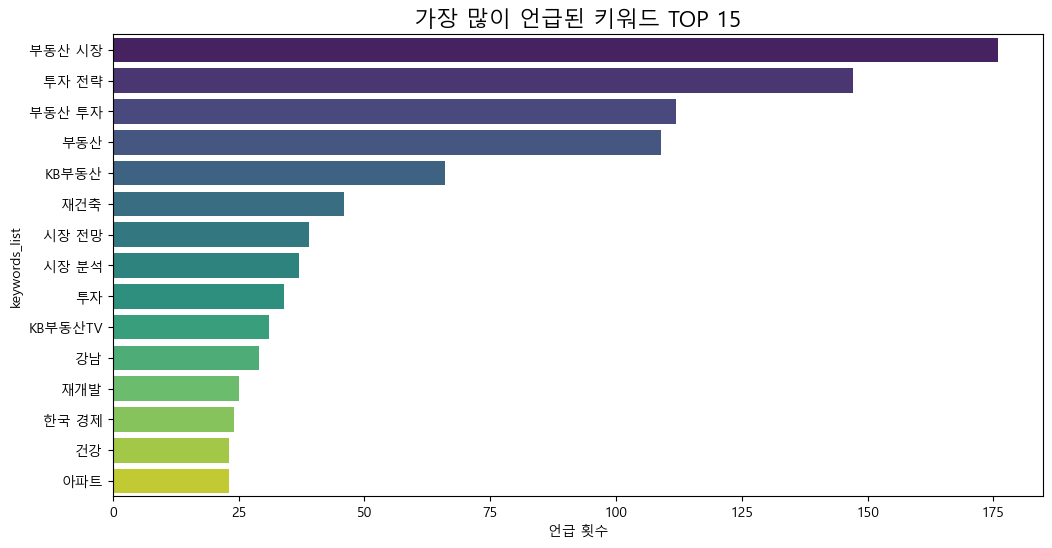

C:\Users\c18197\AppData\Local\Temp\ipykernel_53828\2127679769.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_interviewers.values, y=top_interviewers.index, palette='plasma')


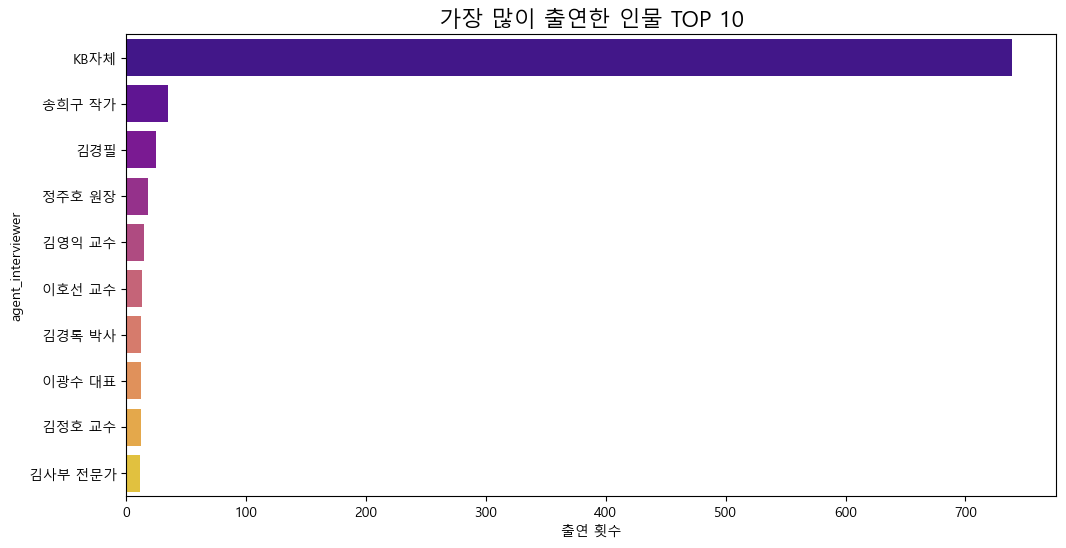

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# 한글 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic)
font_path = "c:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv('final_data_with_agent_analysis.csv')
# 'agent_keywords' 열의 문자열을 실제 키워드 리스트로 변환
df['keywords_list'] = df['agent_keywords'].str.split(', ')
# 각 키워드를 별도의 행으로 분리 (분석을 위해)
keywords_df = df.explode('keywords_list')

# 2. 가장 많이 언급된 키워드 TOP 15
top_keywords = keywords_df['keywords_list'].value_counts().head(15)

# 3. 가장 많이 출연한 인물 TOP 10
interviewers_filtered = df[df['agent_interviewer'] != 'KB자체']
top_interviewers = df['agent_interviewer'].value_counts().head(5)

# 4. 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title('가장 많이 언급된 키워드 TOP 15', fontsize=16)
plt.xlabel('언급 횟수')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_interviewers.values, y=top_interviewers.index, palette='plasma')
plt.title('가장 많이 출연한 인물 TOP 10', fontsize=16)
plt.xlabel('출연 횟수')
plt.show()

## 망고쌤의 전문 분야 키워드 TOP 5
keywords_list
부동산 시장    2
시장 분석     2
시장 전망     2
투자 전략     2
집값 상승     2
Name: count, dtype: int64

## 김경필의 전문 분야 키워드 TOP 5
keywords_list
부동산 투자    7
투자 전략     6
김경필       5
재정 관리     4
부동산 시장    3
Name: count, dtype: int64


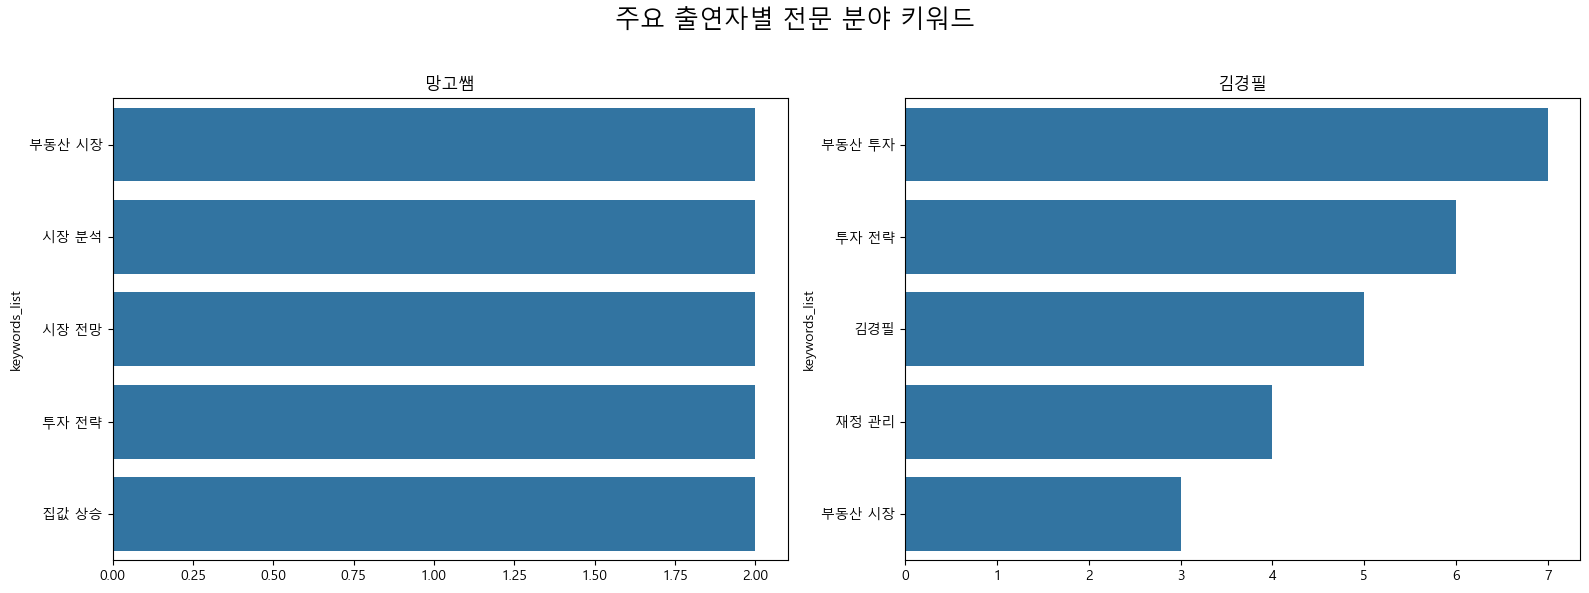

In [5]:
# '망고쌤'과 '김경필'의 전문 분야 키워드 TOP 5 분석
mango_keywords = keywords_df[keywords_df['agent_interviewer'] == '망고쌤']['keywords_list'].value_counts().head(5)
kim_keywords = keywords_df[keywords_df['agent_interviewer'] == '김경필']['keywords_list'].value_counts().head(5)

print("## 망고쌤의 전문 분야 키워드 TOP 5")
print(mango_keywords)
print("\n## 김경필의 전문 분야 키워드 TOP 5")
print(kim_keywords)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('주요 출연자별 전문 분야 키워드', fontsize=18)

sns.barplot(ax=axes[0], x=mango_keywords.values, y=mango_keywords.index)
axes[0].set_title('망고쌤')

sns.barplot(ax=axes[1], x=kim_keywords.values, y=kim_keywords.index)
axes[1].set_title('김경필')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 2023년 인기 키워드 TOP 5
keywords_list
부동산 시장    56
투자 전략     39
부동산       32
부동산 투자    31
KB부동산     16
Name: count, dtype: int64

## 2024년 인기 키워드 TOP 5
keywords_list
부동산 시장    56
투자 전략     42
부동산       33
부동산 투자    32
KB부동산     18
Name: count, dtype: int64


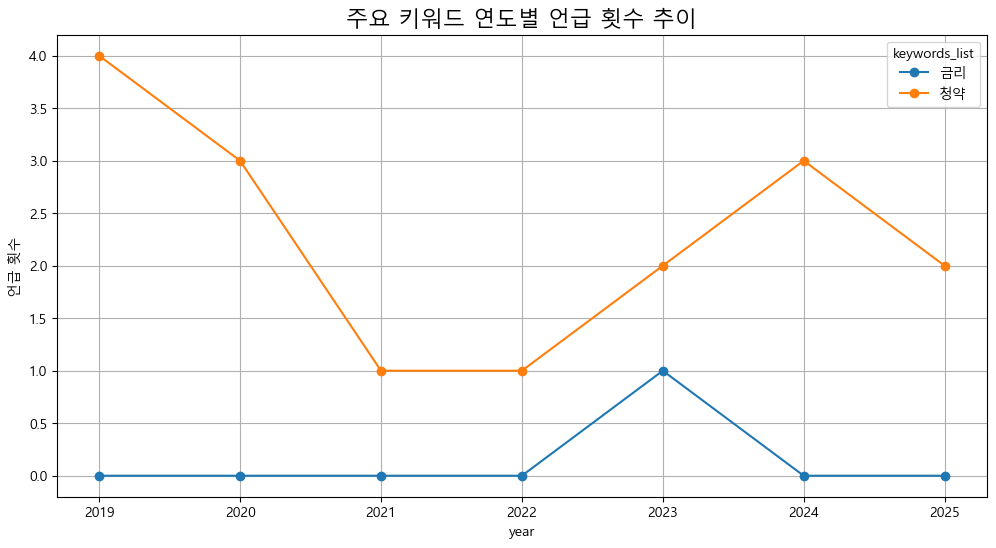

In [6]:
# 'published_at'을 날짜 형식으로 변환하고 'year' 열 추가
df['published_at'] = pd.to_datetime(df['published_at'])
keywords_df['published_at'] = pd.to_datetime(keywords_df['published_at'])
keywords_df['year'] = keywords_df['published_at'].dt.year

# 2023년과 2024년의 TOP 5 키워드 비교
keywords_2023 = keywords_df[keywords_df['year'] == 2023]['keywords_list'].value_counts().head(5)
keywords_2024 = keywords_df[keywords_df['year'] == 2024]['keywords_list'].value_counts().head(5)

print("## 2023년 인기 키워드 TOP 5")
print(keywords_2023)
print("\n## 2024년 인기 키워드 TOP 5")
print(keywords_2024)

# 특정 키워드('금리', '청약')의 연도별 언급 횟수 추이
trend_keywords = ['금리', '청약']
trend_df = keywords_df[keywords_df['keywords_list'].isin(trend_keywords)]
trend_summary = trend_df.groupby(['year', 'keywords_list']).size().unstack(fill_value=0)

# 시각화
trend_summary.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('주요 키워드 연도별 언급 횟수 추이', fontsize=16)
plt.ylabel('언급 횟수')
plt.grid(True)
plt.show()

In [7]:
from bertopic import BERTopic

# 영상 제목 + 키워드를 합쳐 분석할 문서를 만듭니다.
docs = df.apply(lambda row: row['title'] + ' ' + ','.join(row['keywords_list']), axis=1).tolist()

# BERTopic 모델 생성 및 학습
topic_model = BERTopic(language="korean", verbose=True)
topics, probs = topic_model.fit_transform(docs)

# 발견된 주제 확인
print(topic_model.get_topic_info())
# 특정 주제의 키워드 확인
print(topic_model.get_topic(0)) # 0번 주제의 키워드

d:\Application_Temp\youtube-bigdata-agent\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-09 13:38:27,039 - BERTopic - Embedding - Transforming documents to embeddings.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Batches: 100%|██████████| 36/36 [00:02<00:00, 12.18it/s]
2025-09-09 13:39:26,433 - BERTopic - Embedding - Completed ✓
2025-09-09 13:39:26,433 - BERTopic - Dimensionality - Fittin

    Topic  Count                Name  \
0      -1    228     -1_부동산_투자_전략_시장   
1       0    301      0_부동산_강남_투자_시장   
2       1    209      1_부동산_시장_전망_집값   
3       2     71    2_재건축_재개발_gtx_투자   
4       3     56      3_건강_운동_정주호_원장   
5       4     40      4_한국_서울_부동산_시장   
6       5     38     5_투자_자산가_부자_송희구   
7       6     29     6_경제_위기_역전세_경제적   
8       7     29  7_청약_로또_청약통장_체크리스트   
9       8     28   8_세금_세무사_증여_양도소득세   
10      9     28     9_노후_인생_유영만_행복한   
11     10     25    10_한국_한국의_김정호_미래   
12     11     19     11_중국_경제_위기_중국의   
13     12     13  12_정보_kb부동산_집요한_분석   
14     13     12    13_대출_ltv_dsr_규제   

                                       Representation  \
0           [부동산, 투자, 전략, 시장, 교수, 한국, 이유, 경제, 청약, 자산]   
1        [부동산, 강남, 투자, 시장, 전략, 집값, 서울, kb부동산, 교수, 이유]   
2          [부동산, 시장, 전망, 집값, 아파트, 투자, 전략, 분석, 대선, 상승]   
3     [재건축, 재개발, gtx, 투자, 부동산, 시장, 교통, 신도시, 지역, 기대되는]   
4      [건강, 운동, 정주호, 원장, 관리, 단식, 류은경, 조승우, 간헐적, 다이어트]   
5          [한국, 서

In [8]:
import networkx as nx

# 네트워크 그래프 생성
G = nx.Graph()

# 각 영상을 순회하며 노드(키워드, 출연자)와 엣지(연결) 추가
for index, row in df.iterrows():
    interviewer = row['agent_interviewer']
    keywords = row['keywords_list']
    
    # 출연자가 'KB자체'가 아닐 경우에만 노드로 추가
    if interviewer != 'KB자체':
        G.add_node(interviewer, type='interviewer')
        for keyword in keywords:
            G.add_node(keyword, type='keyword')
            G.add_edge(interviewer, keyword)

# 가장 연결성이 높은(중심적인) 노드 찾기
centrality = nx.degree_centrality(G)
sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
print(sorted_centrality[:10])

[('송희구 작가', 0.10157618213660245), ('김경필', 0.07793345008756568), ('정주호 원장', 0.05866900175131348), ('김영익 교수', 0.04816112084063047), ('이호선 교수', 0.0446584938704028), ('김정호 교수', 0.043782837127845885), ('김경록 박사', 0.04290718038528897), ('이광수 대표', 0.04290718038528897), ('조영광 연구원', 0.0394045534150613), ('김사부 전문가', 0.03852889667250438)]


In [9]:
import pandas as pd

# 1. 데이터 불러오기 및 키워드 리스트 전처리
df = pd.read_csv('final_data_with_agent_analysis.csv')
# agent_keywords가 문자열일 경우를 대비하여 처리
df['keywords_list'] = df['agent_keywords'].astype(str).str.split(', ')

# 2. 제외할 키워드 리스트 정의 (건강/운동 관련)
non_real_estate_keywords = ['건강', '운동', '다이어트', '원장', '단식', '관리']

# 3. 각 영상의 키워드 리스트에 제외할 키워드가 포함되어 있는지 확인하는 함수
def is_real_estate_related(keywords):
    # keywords가 리스트가 아닐 경우를 대비
    if not isinstance(keywords, list):
        return True # 데이터가 이상할 경우 일단 포함
    # 제외 키워드가 하나라도 있으면 False 반환
    return not any(keyword in keywords for keyword in non_real_estate_keywords)

# 4. 부동산 관련 영상만 필터링
df_real_estate = df[df['keywords_list'].apply(is_real_estate_related)].copy()

print(f"✅ 부동산 비관련 콘텐츠 제외 완료.")
print(f"원본 데이터: {len(df)}개 -> 필터링 후 데이터: {len(df_real_estate)}개")

✅ 부동산 비관련 콘텐츠 제외 완료.
원본 데이터: 1126개 -> 필터링 후 데이터: 1093개


In [10]:
# 분석의 편의를 위해 키워드를 행으로 분리한 데이터프레임 생성
keywords_df = df_real_estate.explode('keywords_list')
# 'KB자체'는 분석에서 제외
experts_df = keywords_df[keywords_df['agent_interviewer'] != 'KB자체']

# 1. 전문가별 출연 횟수 계산
expert_counts = df_real_estate['agent_interviewer'].value_counts().drop('KB자체', errors='ignore')

# 2. 전문가별 TOP 5 키워드 추출
expert_top_keywords = experts_df.groupby('agent_interviewer')['keywords_list'].apply(lambda x: x.value_counts().head(5))

# 3. 결과 취합
expert_summary = pd.DataFrame(expert_counts).rename(columns={'count': '출연 횟수'})
expert_summary['TOP 5 키워드'] = expert_summary.index.map(expert_top_keywords.groupby(level=0).apply(lambda x: list(x.index)))

print("\n##  전문가별 출연 횟수 및 TOP 5 키워드")
print(expert_summary.head(10)) # 상위 10명만 출력


##  전문가별 출연 횟수 및 TOP 5 키워드
                   출연 횟수                                          TOP 5 키워드
agent_interviewer                                                          
송희구 작가                35  [(송희구 작가, 투자 전략), (송희구 작가, 송희구), (송희구 작가, 부동산 ...
김경필                   25  [(김경필, 부동산 투자), (김경필, 투자 전략), (김경필, 김경필), (김경필...
김영익 교수                15  [(김영익 교수, 김영익 교수), (김영익 교수, 부동산 시장), (김영익 교수, ...
이광수 대표                12  [(이광수 대표, 이광수 대표), (이광수 대표, 부동산 시장), (이광수 대표, ...
김경록 박사                12  [(김경록 박사, 부동산 투자), (김경록 박사, 노후 준비), (김경록 박사, 투...
김정호 교수                12  [(김정호 교수, 김정호 교수), (김정호 교수, 트럼프 당선), (김정호 교수, ...
이호선 교수                11  [(이호선 교수, 이호선 교수), (이호선 교수, 노후 준비), (이호선 교수, K...
터보832                 11  [(터보832, 상위 0.1%), (터보832, 부동산 시장), (터보832, 부자...
김사부 전문가               11  [(김사부 전문가, 부동산 투자), (김사부 전문가, 투자 전략), (김사부 전문가...
조규원 대표                10  [(조규원 대표, 금 투자), (조규원 대표, 조규원), (조규원 대표, 금거래소)...


In [11]:
# 1. 날짜 형식 변환 및 TOP 5 전문가 리스트 정의
df_real_estate['published_at'] = pd.to_datetime(df_real_estate['published_at'])
top_5_experts = ['김경필', '망고쌤', '송희구 작가', '이장원 세무사', '김영익 교수']

# 2. 각 전문가별로 최신 영상 1~2개씩 추출
validation_videos = (
    df_real_estate[df_real_estate['agent_interviewer'].isin(top_5_experts)]
    .sort_values('published_at', ascending=False)
    .groupby('agent_interviewer')
    .head(2) # 각 전문가별 최신 2개 영상
)

print("\n## 🧐 교차검증을 위한 전문가별 최신 영상 리스트")
print(validation_videos[['published_at', 'agent_interviewer', 'title']])


## 🧐 교차검증을 위한 전문가별 최신 영상 리스트
     published_at agent_interviewer  \
0      2025-09-08               망고쌤   
2      2025-09-07               망고쌤   
7      2025-09-03           이장원 세무사   
8      2025-09-03               김경필   
9      2025-09-02            송희구 작가   
11     2025-09-02               김경필   
12     2025-09-01           이장원 세무사   
14     2025-08-27            송희구 작가   
1003   2024-12-11            김영익 교수   
1001   2024-12-10            김영익 교수   

                                                  title  
0                                지금 부동산 시장이 바닥인 이유 #망고쌤  
2                집값 곧 무섭게 바뀝니다. 제발 '이것'부터 보세요 (망고쌤 풀버전)  
7     세무조사 기준 대폭 강화! 증여세 줄이려다 세금 폭탄 맞을 수 있습니다 (이장원 세...  
8                            이 조건 안 되면 절대 집 사지 마세요 #김경필  
9     자금 1억 모아서 부동산 투자? 음~ 일단 뽀뽀해 드릴게요!💋 (아낌없이 주는 희구...  
11                       강남 영끌 성공했지만 절대 추천 안 하는 이유 #김경필  
12    2025 부동산 세제 개편?! 세금 폭탄 피하려면 올해 안에 '이것'부터 하세요 (...  
14        영끌'해도 괜찮을까? 그럴 땐 이렇게 대처해보세요! (아낌없이 주는 희구 11부)  
1003         IMF보다